In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import torch
import torchaudio
import seaborn as sns
import helper_functions
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
from sympy import re
import torch.nn as nn
from cv2 import line
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split



In [35]:
eeg_df= pd.read_csv('eeg_Eye_State_Classification.csv')

print(f"shape: {eeg_df.shape}")

shape: (14980, 15)


In [170]:
print(eeg_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB
None


In [171]:
eeg_df.describe()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
count,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000,14980.000000
mean,4321.917777,4009.767694,4264.022433,4164.946326,4341.741075,4644.022379,4110.400160,4616.056904,4218.826610,4231.316200,4202.456900,4279.232774,4615.205336,4416.435832,0.448798
std,2492.072174,45.941672,44.428052,5216.404632,34.738821,2924.789537,4600.926543,29.292603,2136.408523,38.050903,37.785981,41.544312,1208.369958,5891.285043,0.497388
min,1030.770000,2830.770000,1040.000000,2453.330000,2089.740000,2768.210000,2086.150000,4567.180000,1357.950000,1816.410000,3273.330000,2257.950000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,309231.000000,7804.620000,6880.510000,642564.000000,6474.360000,362564.000000,567179.000000,7264.100000,265641.000000,6674.360000,6823.080000,7002.560000,152308.000000,715897.000000,1.000000


## class distribution

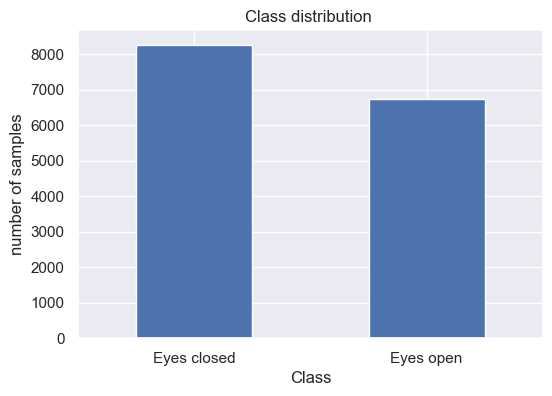

In [172]:
class_counts = eeg_df['eyeDetection'].value_counts()

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("number of samples")
plt.title("Class distribution ")
plt.xticks(ticks=[0, 1], labels=["Eyes closed", "Eyes open"], rotation=0)
plt.show()


## chaneels visualization

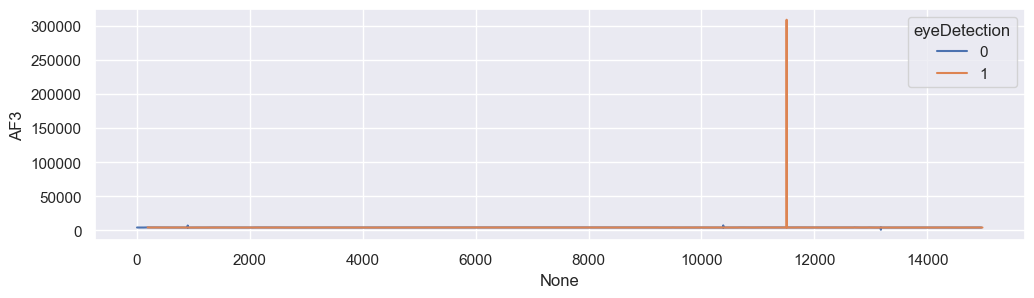

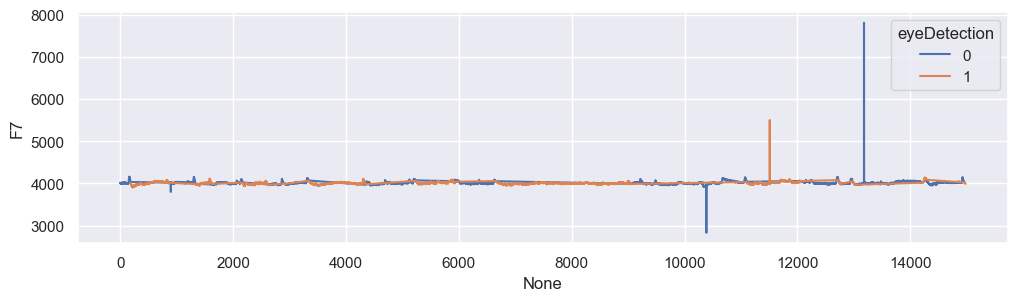

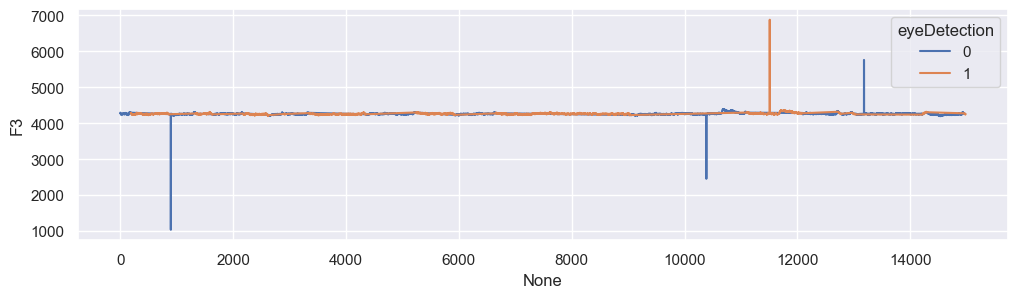

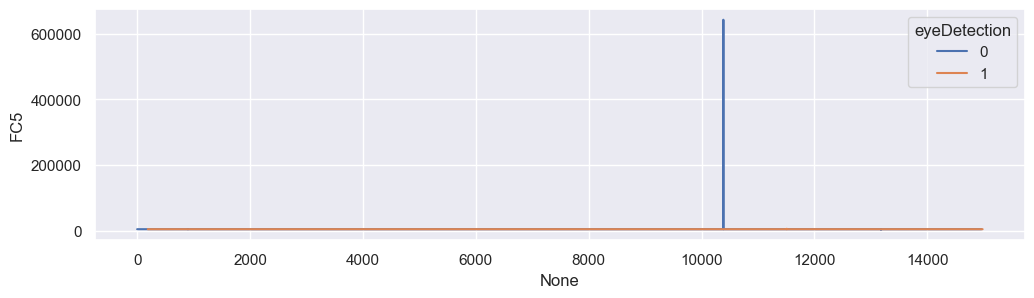

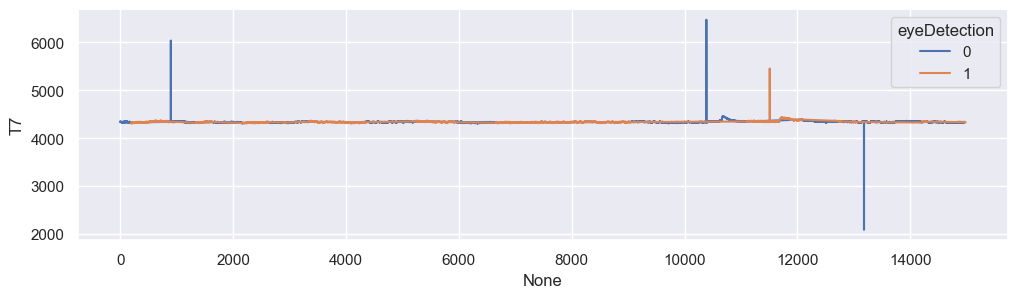

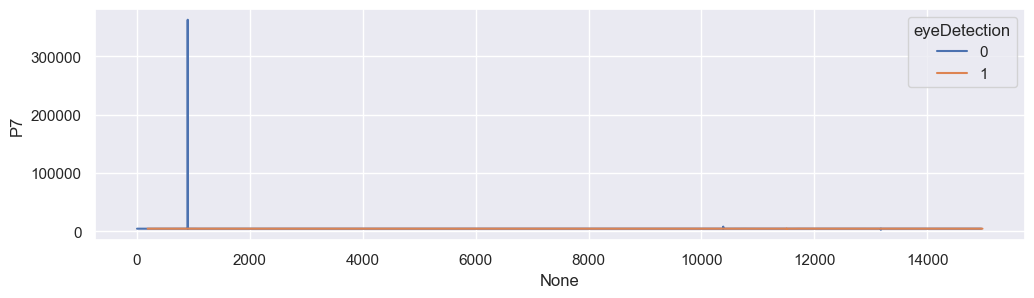

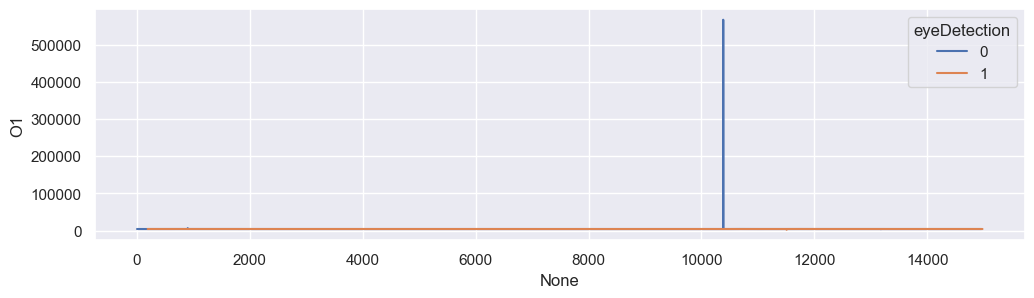

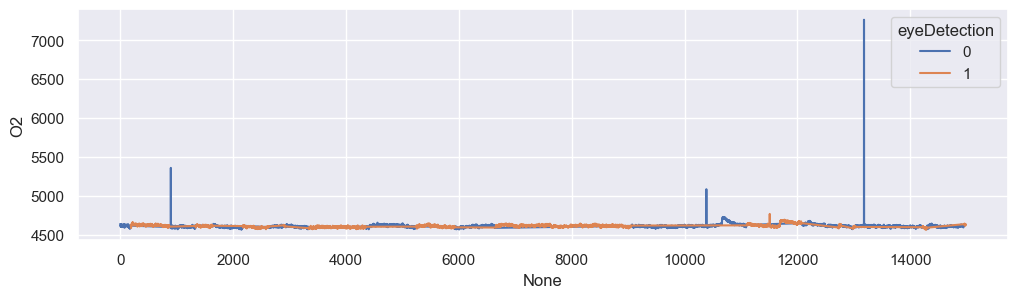

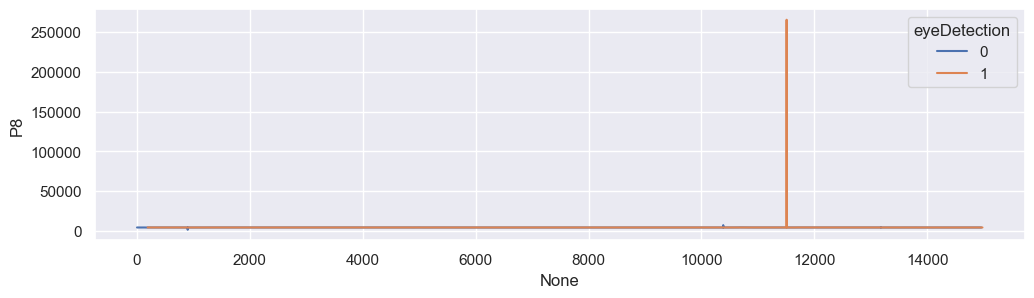

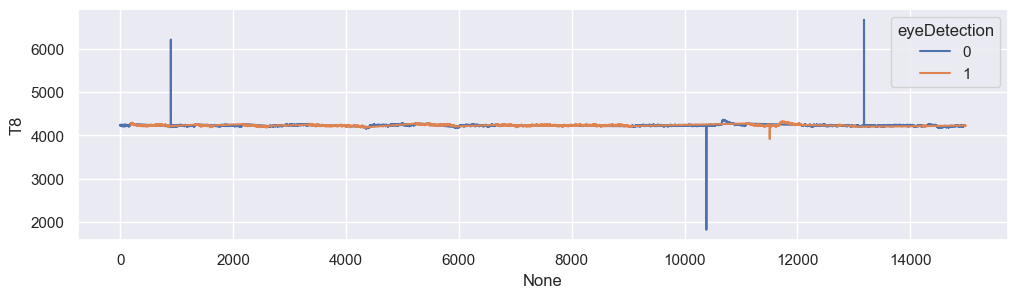

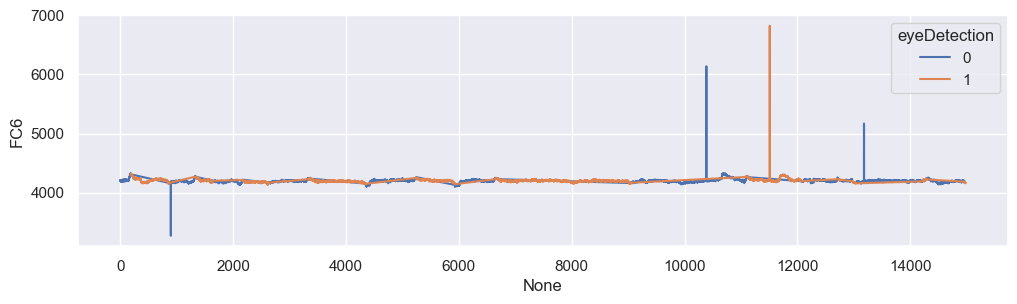

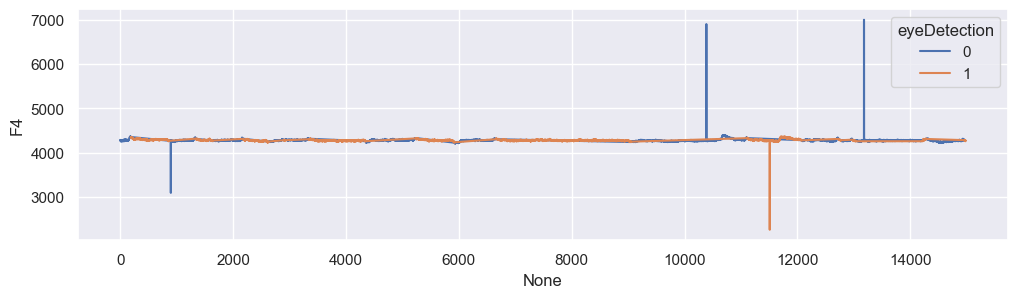

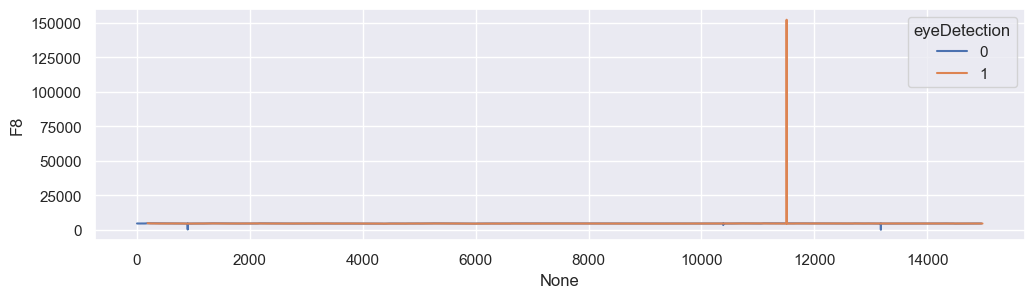

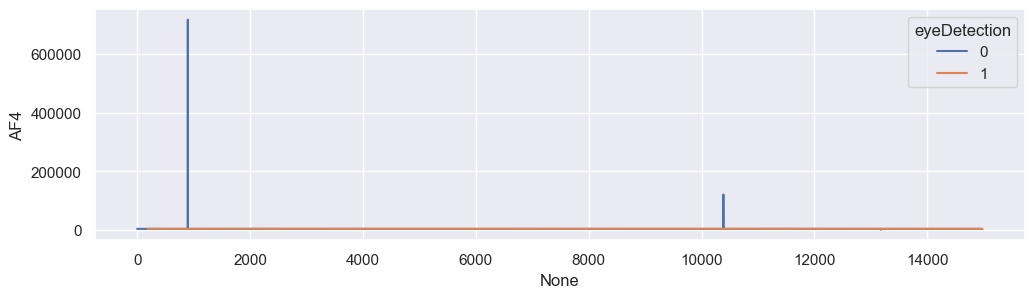

In [173]:
sns.set_theme(style='darkgrid')
for col in eeg_df.columns[0:-1]:
    plt.figure(figsize=(12, 3))
    sns.lineplot(x=eeg_df.index, y=col, data=eeg_df, hue="eyeDetection")
    plt.show()

## eye state visualization

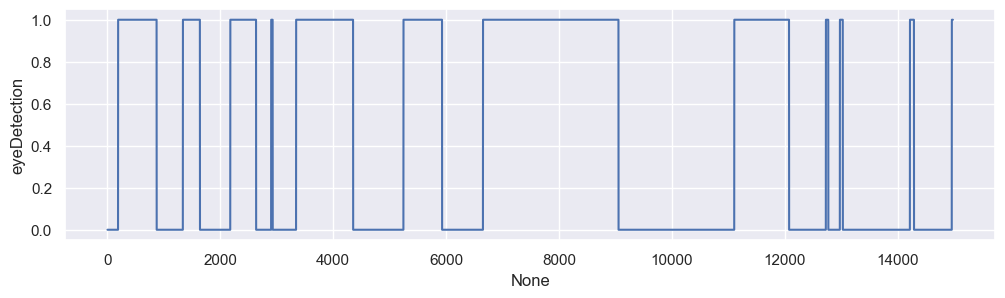

In [174]:
plt.figure(figsize=(12, 3))
sns.lineplot(x=eeg_df.index, y=eeg_df.columns[-1], data=eeg_df)
plt.show()

In [175]:
channels = eeg_df.columns
corr_matrix = eeg_df[channels].corr()


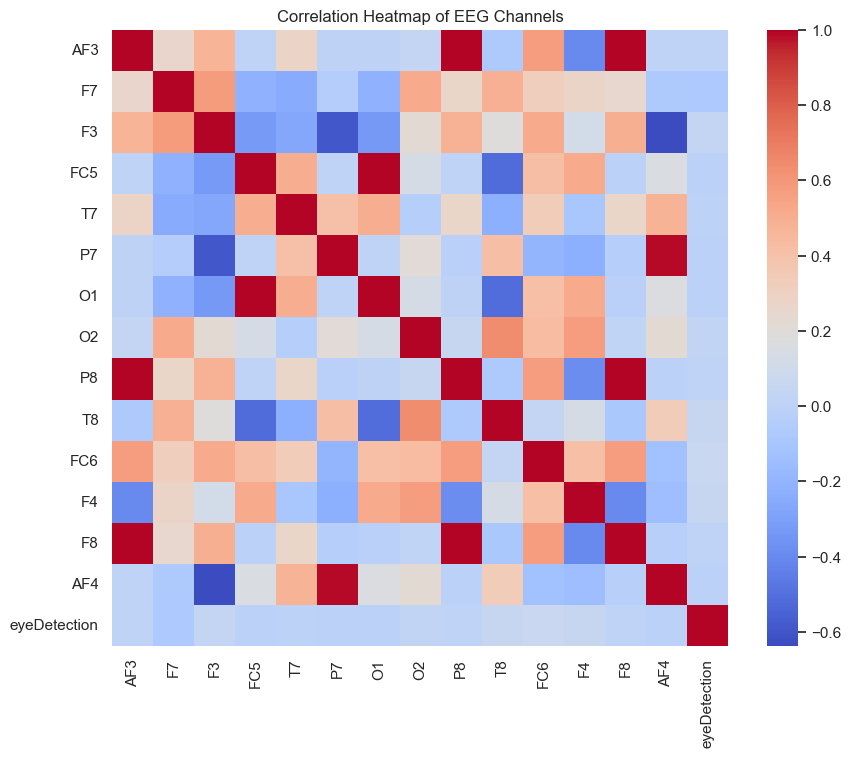

In [176]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=False,
    square=True
)
plt.title("Correlation Heatmap of EEG Channels")
plt.show()


## outlier removal


In [36]:
y=eeg_df['eyeDetection']
eeg_df=eeg_df.drop(columns=['eyeDetection'])

In [178]:
eeg_df.shape

(14980, 14)

In [4]:
abs_z_scores= np.abs(scipy.stats.zscore(eeg_df,axis=0))
eeg_df_filtred= eeg_df.copy()
eeg_df_filtred[abs_z_scores>=10]= np.nan
eeg_df_filtred.isna().sum().sum()


np.int64(33)

In [245]:
tras=[3,5,10,15,20,50,100]
for t in tras:
    abs_z_scores= np.abs(scipy.stats.zscore(eeg_df,axis=0))
    eeg_df_filtred= eeg_df.copy()
    eeg_df_filtred[abs_z_scores>=t]= np.nan
    droped_count=eeg_df_filtred.isna().sum().sum()
    print(f'{droped_count} values {t} std far from the mean')


209 values 3 std far from the mean
35 values 5 std far from the mean
33 values 10 std far from the mean
33 values 15 std far from the mean
31 values 20 std far from the mean
20 values 50 std far from the mean
7 values 100 std far from the mean


## using trashold of 10

In [5]:
abs_z_scores= np.abs(scipy.stats.zscore(eeg_df,axis=0))
eeg_df_filtred= eeg_df.copy()
eeg_df_filtred[abs_z_scores>=10]= np.nan
eeg_df_filtred.isna().sum()



AF3    1
F7     3
F3     4
FC5    1
T7     4
P7     1
O1     1
O2     3
P8     1
T8     3
FC6    4
F4     4
F8     1
AF4    2
dtype: int64

## Interpolate missing values using cubic spline interpolation

In [6]:
eeg_df_interp = eeg_df_filtred.interpolate(
    method="spline",
    order=3,
    axis=0,
    limit_direction="both"
)


In [7]:
sfreq = 128
t = np.arange(len(eeg_df)) / sfreq

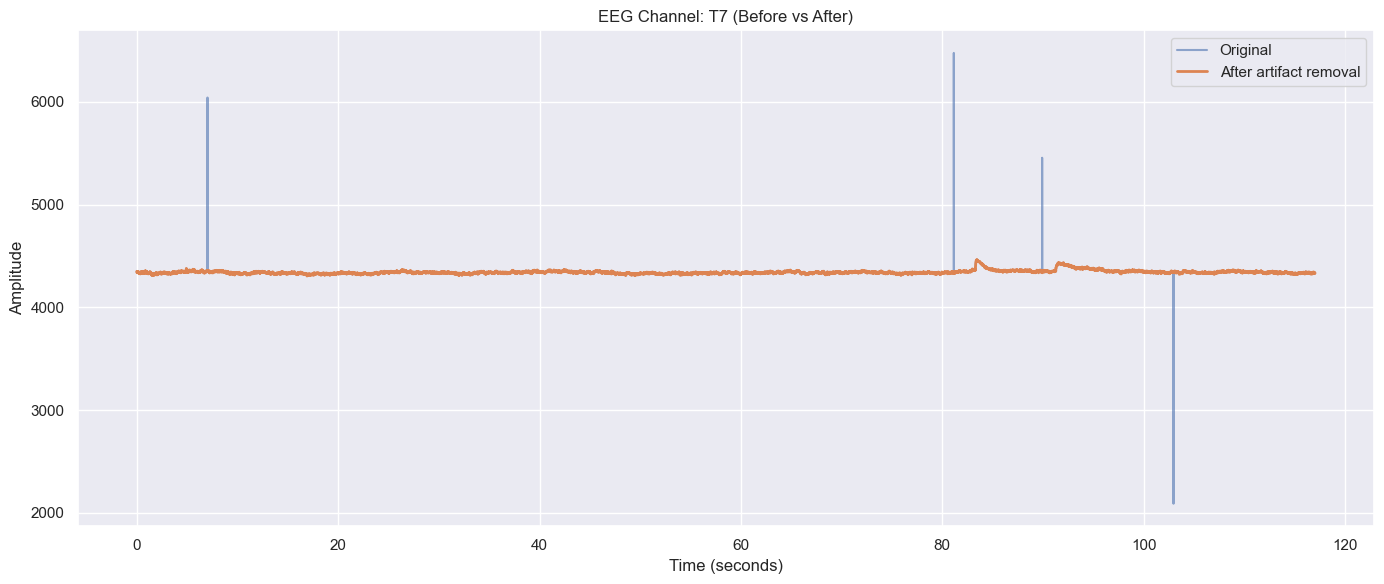

In [184]:
plt.figure(figsize=(14, 6))

# Before
plt.plot(t, eeg_df['T7'], 
         label="Original", 
         alpha=0.6)

# After
plt.plot(t, eeg_df_interp['T7'], 
         label="After artifact removal", 
         linewidth=2)

plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title(f"EEG Channel: T7 (Before vs After)")
plt.legend()
plt.tight_layout()
plt.show()


## apply bandBass filter

In [8]:
nyquist = sfreq/ 2
low = 8 / nyquist
high = 13 / nyquist
b,a=scipy.signal.butter(4,[low,high],btype='band')

In [9]:
band_filt_eeg=pd.DataFrame()
for ch in eeg_df_interp.columns:

    b_f_eeg=scipy.signal.filtfilt(b,a,eeg_df_interp[ch])
    band_filt_eeg[ch]=b_f_eeg


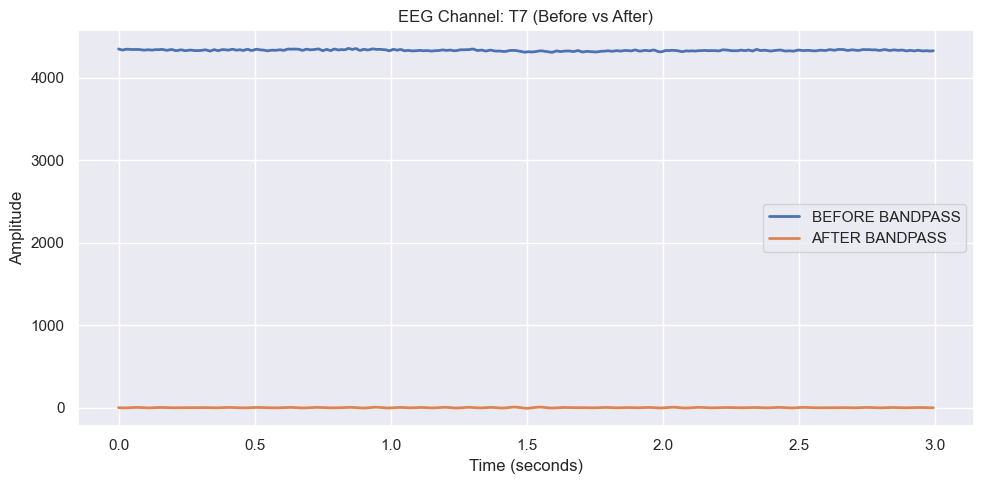

In [187]:
plt.figure(figsize=(10, 5))

plt.plot(t[:3*128], eeg_df_interp['T7'][:3*128], 
         label="BEFORE BANDPASS", 
         linewidth=2)
plt.plot(t[:3*128], band_filt_eeg['T7'][:3*128], 
         label="AFTER BANDPASS", 
         linewidth=2)

plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title(f"EEG Channel: T7 (Before vs After)")
plt.legend()
plt.tight_layout()
plt.show()


## normalize using Zscore

In [10]:
eeg_norm=band_filt_eeg.apply(scipy.stats.zscore)

In [189]:
# eeg_norm = (band_filt_eeg - band_filt_eeg.mean()) / band_filt_eeg.std()


In [190]:
print(eeg_norm.mean())
print(eeg_norm.std())

AF3   -1.608267e-18
F7     1.747601e-17
F3    -1.838019e-17
FC5   -3.409230e-19
T7     1.618643e-17
P7    -3.498166e-18
O1     1.430394e-18
O2    -2.377567e-17
P8     7.411369e-20
T8    -7.129737e-18
FC6    8.760238e-18
F4    -3.142420e-18
F8    -3.861323e-18
AF4    5.084199e-18
dtype: float64
AF3    1.000033
F7     1.000033
F3     1.000033
FC5    1.000033
T7     1.000033
P7     1.000033
O1     1.000033
O2     1.000033
P8     1.000033
T8     1.000033
FC6    1.000033
F4     1.000033
F8     1.000033
AF4    1.000033
dtype: float64


## feature extraction

In [191]:
features={}

for ch in eeg_norm.columns:
    features[ch]=helper_functions.extract_features(eeg_norm[ch])
    


In [192]:
comparison_df = pd.DataFrame(features).T
comparison_df

,Mean,Std,var,RMS,Peak,Skewness,Kurtosis,Crest Factor,Shannon Entropy,Zero-Crossing Rate
AF3,-1.608267e-18,1.000033,1.000067,1.0,21.560692,0.002102,202.499040,21.560692,0.214764,0.162561
F7,1.747601e-17,1.000033,1.000067,1.0,5.721310,0.000462,0.844901,5.721310,1.366476,0.160825
F3,-1.838019e-17,1.000033,1.000067,1.0,5.422855,0.000047,1.148886,5.422855,1.382741,0.161292
FC5,-3.409230e-19,1.000033,1.000067,1.0,25.106107,-0.002703,211.588183,25.106107,0.076621,0.162227
T7,1.618643e-17,1.000033,1.000067,1.0,4.985529,0.000266,0.153826,4.985529,1.471453,0.163095
P7,-3.498166e-18,1.000033,1.000067,1.0,31.518822,0.008434,411.111762,31.518822,0.053362,0.163763
O1,1.430394e-18,1.000033,1.000067,1.0,25.486862,0.001823,268.443712,25.486862,0.062158,0.163496
O2,-2.377567e-17,1.000033,1.000067,1.0,4.733298,0.000117,0.631459,4.733298,1.501424,0.168836
P8,7.411369e-20,1.000033,1.000067,1.0,23.741109,0.000709,236.804680,23.741109,0.663127,0.167368
T8,-7.129737e-18,1.000033,1.000067,1.0,6.563792,0.000366,1.269233,6.563792,1.241299,0.166233


<Axes: >

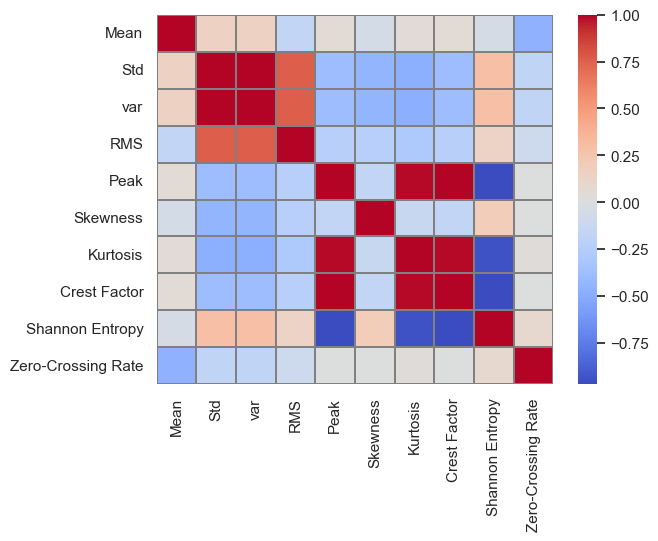

In [193]:
corr=comparison_df.corr()

sns.heatmap(corr,cmap="coolwarm",annot=False,linewidths=0.003,linecolor='grey')

## spectiral Features 

In [194]:
spec_features={}
for ch in eeg_norm.columns:
    spec_features[ch]=helper_functions.spectral_features(eeg_norm[ch],sfreq)

spec_comparisson_df=pd.DataFrame(spec_features).T
spec_comparisson_df

,delta_abs,delta_rel,theta_abs,theta_rel,alpha_abs,alpha_rel,beta_abs,beta_rel,gamma_abs,gamma_rel,spectral_centroid,spectral_entropy
AF3,820.308419,7.311114e-06,1.271619e+06,0.011333,1.089782e+08,0.971283,1.949474e+06,0.017375,15.941372,1.420797e-07,10.469665,8.798123
F7,7666.371872,6.832761e-05,1.437931e+06,0.012816,1.092902e+08,0.974064,1.463340e+06,0.013042,152.617012,1.360220e-06,10.160997,8.632828
F3,648.292868,5.778001e-06,1.858454e+06,0.016564,1.090130e+08,0.971594,1.327673e+06,0.011833,241.427301,2.151755e-06,10.232276,8.649116
FC5,55.262721,4.925367e-07,1.089264e+06,0.009708,1.093288e+08,0.974408,1.781925e+06,0.015882,121.534758,1.083196e-06,10.429795,8.781554
T7,6747.074644,6.013425e-05,1.538322e+06,0.013711,1.093180e+08,0.974312,1.335623e+06,0.011904,551.767033,4.917701e-06,10.323489,8.661036
P7,4.573110,4.075849e-08,1.179923e+06,0.010516,1.091214e+08,0.972560,1.898892e+06,0.016924,0.535921,4.776475e-09,10.521274,8.937882
O1,269.752363,2.404206e-06,1.220357e+06,0.010877,1.089483e+08,0.971017,2.031225e+06,0.018104,35.549359,3.168386e-07,10.477011,8.809432
O2,514.993168,4.589949e-06,6.457389e+05,0.005755,1.095590e+08,0.976460,1.994932e+06,0.017780,3.274948,2.918844e-08,10.668301,8.581664
P8,261.859844,2.333863e-06,1.179930e+06,0.010516,1.091492e+08,0.972807,1.870788e+06,0.016674,1.680988,1.498204e-08,10.499317,8.785666
T8,3775.206929,3.364706e-05,1.110327e+06,0.009896,1.099592e+08,0.980026,1.126411e+06,0.010039,59.235045,5.279406e-07,10.383634,8.609641


<Axes: >

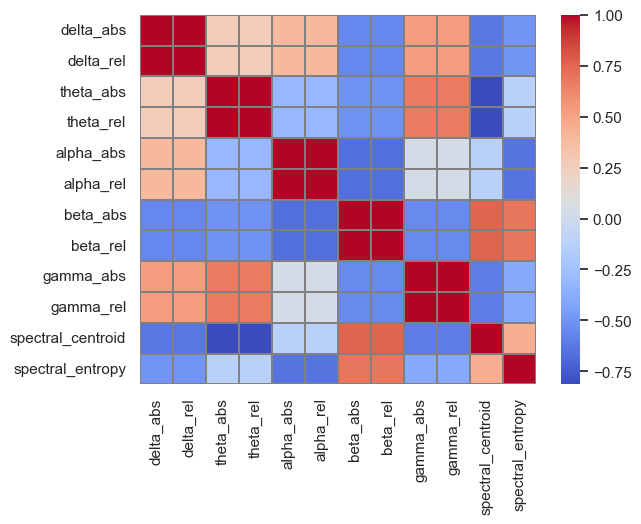

In [ ]:



corr=spec_comparisson_df.corr()

sns.heatmap(corr,cmap="coolwarm",annot=False,linewidths=0.003,linecolor='grey')

In [196]:
import importlib
import helper_functions

importlib.reload(helper_functions)


<module 'helper_functions' from 'c:\\Users\\hana\\OneDrive\\Documents\\GitHub\\EEG-Eye-state-classifier\\helper_functions.py'>

In [252]:
helper_functions.extract_features(eeg_norm)

{'Mean': AF3   -1.608267e-18
 F7     1.747601e-17
 F3    -1.838019e-17
 FC5   -3.409230e-19
 T7     1.618643e-17
 P7    -3.498166e-18
 O1     1.430394e-18
 O2    -2.377567e-17
 P8     7.411369e-20
 T8    -7.129737e-18
 FC6    8.760238e-18
 F4    -3.142420e-18
 F8    -3.861323e-18
 AF4    5.084199e-18
 dtype: float64,
 'Std': AF3    1.000033
 F7     1.000033
 F3     1.000033
 FC5    1.000033
 T7     1.000033
 P7     1.000033
 O1     1.000033
 O2     1.000033
 P8     1.000033
 T8     1.000033
 FC6    1.000033
 F4     1.000033
 F8     1.000033
 AF4    1.000033
 dtype: float64,
 'var': AF3    1.000067
 F7     1.000067
 F3     1.000067
 FC5    1.000067
 T7     1.000067
 P7     1.000067
 O1     1.000067
 O2     1.000067
 P8     1.000067
 T8     1.000067
 FC6    1.000067
 F4     1.000067
 F8     1.000067
 AF4    1.000067
 dtype: float64,
 'RMS': np.float64(1.0),
 'Peak': np.float64(31.518821898020455),
 'Skewness': array([ 2.10154362e-03,  4.61583594e-04,  4.69799854e-05, -2.70289308e-03,
   

In [ ]:
# X = eeg_norm.drop(columns=['eyeDetection'])
# y = eeg_norm['eyeDetection']


KeyError: "['eyeDetection'] not found in axis"

In [ ]:
features={}

for ch in eeg_norm.columns:
    features[ch]=helper_functions.features(eeg_norm[ch])
    
features_df = pd.DataFrame(features).T
features_df


,delta_abs,delta_rel,theta_abs,theta_rel,alpha_abs,alpha_rel,beta_abs,beta_rel,gamma_abs,gamma_rel,...,mean,std,var,rms,peak,skewness,kurtosis,crest_factor,shannon_entropy,zcr
AF3,820.308419,7.311114e-06,1.271619e+06,0.011333,1.089782e+08,0.971283,1.949474e+06,0.017375,15.941372,1.420797e-07,...,-1.608267e-18,1.0,1.0,1.0,21.560692,0.002102,202.499040,21.560692,0.214764,0.162561
F7,7666.371872,6.832761e-05,1.437931e+06,0.012816,1.092902e+08,0.974064,1.463340e+06,0.013042,152.617012,1.360220e-06,...,1.747601e-17,1.0,1.0,1.0,5.721310,0.000462,0.844901,5.721310,1.366476,0.160825
F3,648.292868,5.778001e-06,1.858454e+06,0.016564,1.090130e+08,0.971594,1.327673e+06,0.011833,241.427301,2.151755e-06,...,-1.838019e-17,1.0,1.0,1.0,5.422855,0.000047,1.148886,5.422855,1.382741,0.161292
FC5,55.262721,4.925367e-07,1.089264e+06,0.009708,1.093288e+08,0.974408,1.781925e+06,0.015882,121.534758,1.083196e-06,...,-3.409230e-19,1.0,1.0,1.0,25.106107,-0.002703,211.588183,25.106107,0.076621,0.162227
T7,6747.074644,6.013425e-05,1.538322e+06,0.013711,1.093180e+08,0.974312,1.335623e+06,0.011904,551.767033,4.917701e-06,...,1.618643e-17,1.0,1.0,1.0,4.985529,0.000266,0.153826,4.985529,1.471453,0.163095
P7,4.573110,4.075849e-08,1.179923e+06,0.010516,1.091214e+08,0.972560,1.898892e+06,0.016924,0.535921,4.776475e-09,...,-3.498166e-18,1.0,1.0,1.0,31.518822,0.008434,411.111762,31.518822,0.053362,0.163763
O1,269.752363,2.404206e-06,1.220357e+06,0.010877,1.089483e+08,0.971017,2.031225e+06,0.018104,35.549359,3.168386e-07,...,1.430394e-18,1.0,1.0,1.0,25.486862,0.001823,268.443712,25.486862,0.062158,0.163496
O2,514.993168,4.589949e-06,6.457389e+05,0.005755,1.095590e+08,0.976460,1.994932e+06,0.017780,3.274948,2.918844e-08,...,-2.377567e-17,1.0,1.0,1.0,4.733298,0.000117,0.631459,4.733298,1.501424,0.168836
P8,261.859844,2.333863e-06,1.179930e+06,0.010516,1.091492e+08,0.972807,1.870788e+06,0.016674,1.680988,1.498204e-08,...,7.411369e-20,1.0,1.0,1.0,23.741109,0.000709,236.804680,23.741109,0.663127,0.167368
T8,3775.206929,3.364706e-05,1.110327e+06,0.009896,1.099592e+08,0.980026,1.126411e+06,0.010039,59.235045,5.279406e-07,...,-7.129737e-18,1.0,1.0,1.0,6.563792,0.000366,1.269233,6.563792,1.241299,0.166233


<Axes: >

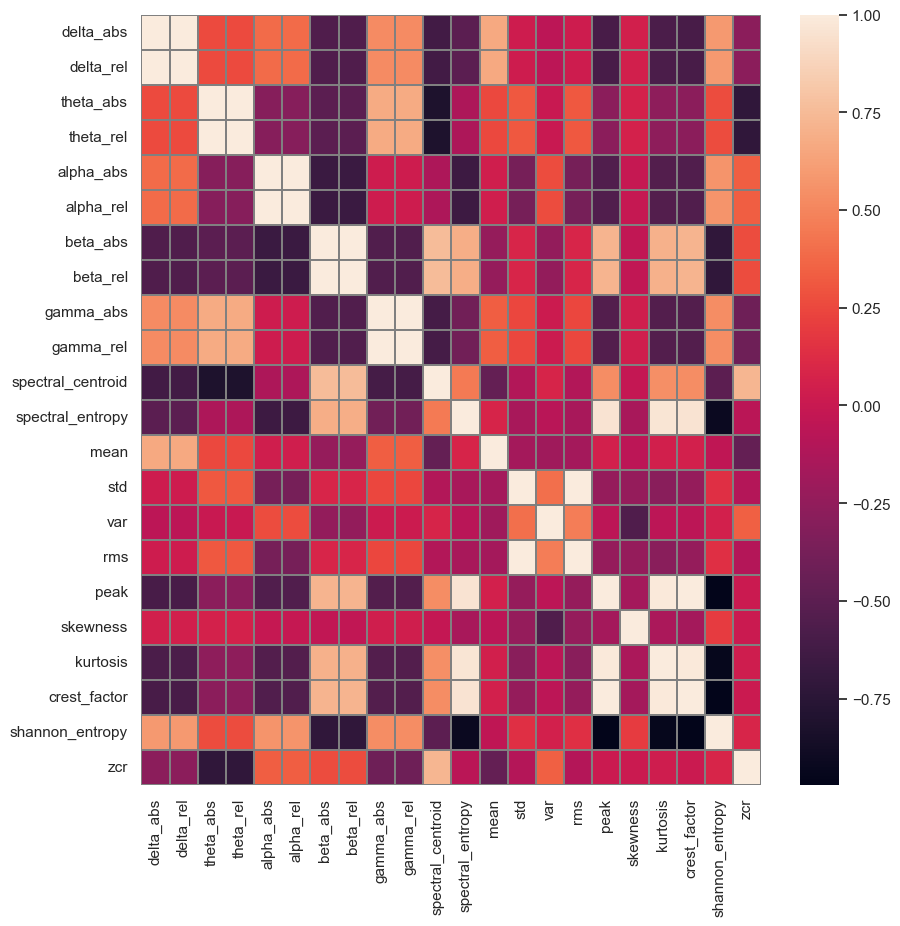

In [200]:
plt.figure(figsize=(10, 10))
corr=features_df.corr()

sns.heatmap(corr,annot=False,linewidths=0.003,linecolor='grey')

In [201]:
threshold = 0.8
upper_triangle = corr.where(
    np.triu(np.ones(corr.shape), k=1).astype(bool)
)

to_drop = [
    column for column in upper_triangle.columns
    if any(upper_triangle[column] > threshold)
]

features_reduced = features_df.drop(columns=to_drop)


In [202]:
features_df.shape

(14, 22)

In [203]:
to_drop

['delta_rel',
 'theta_rel',
 'alpha_rel',
 'beta_rel',
 'gamma_rel',
 'rms',
 'peak',
 'kurtosis',
 'crest_factor']

In [ ]:
print(f"Original number of features: {eeg_norm.shape[1]}")
print(f"Number of removed features: {len(to_drop)}")
print("Removed features:")
for f in to_drop:
    print("-", f)


Original number of features: 14
Number of removed features: 9
Removed features:
- delta_rel
- theta_rel
- alpha_rel
- beta_rel
- gamma_rel
- rms
- peak
- kurtosis
- crest_factor


<Axes: >

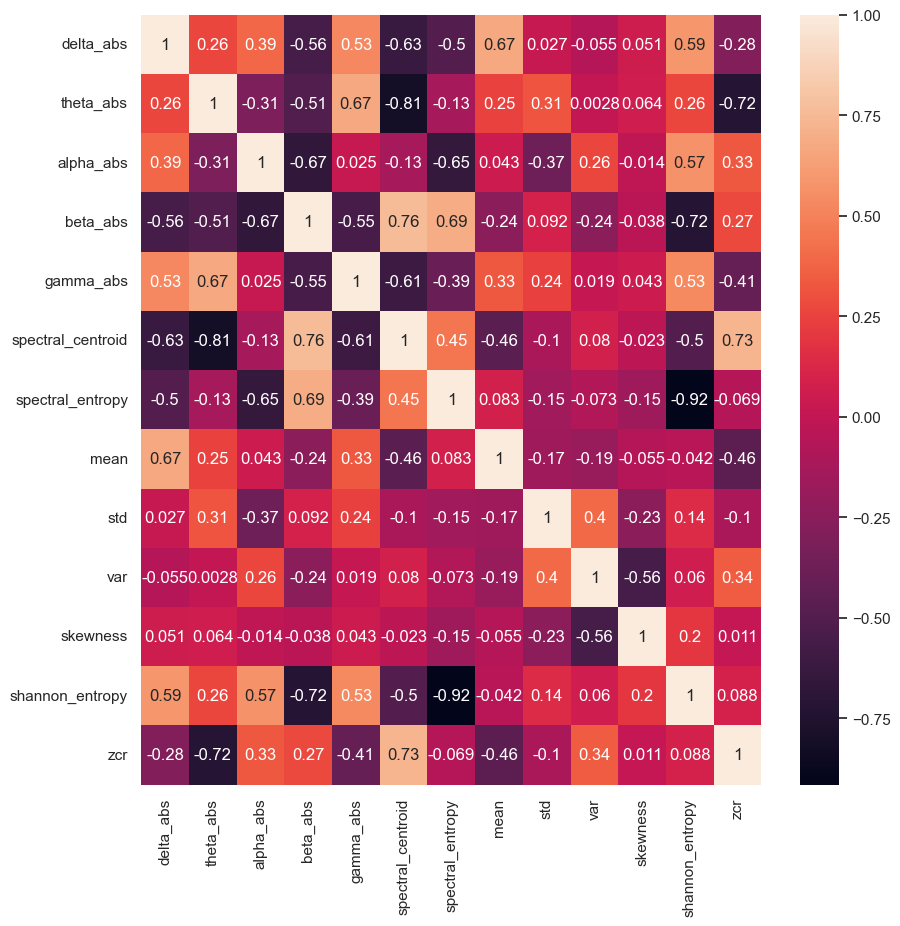

In [205]:
plt.figure(figsize=(10, 10))

sns.heatmap(features_reduced.corr(),annot=True)

In [206]:
from sklearn.decomposition import PCA
pca=PCA()

features_pca=pca.fit_transform(features_reduced)
features_pca

array([[ 4.71380242e+05,  1.21080297e+05,  2.17663372e+02,
        -7.64221104e+01,  1.99520620e-01, -5.81347015e-02,
        -4.75518309e-02,  2.36405365e-02,  1.97241527e-03,
        -7.30291898e-04,  3.72742127e-17, -2.29263784e-17,
         3.81465332e-18],
       [-1.26272051e+05,  1.85454692e+05,  6.15634023e+03,
        -1.71506676e+02, -6.77155014e-01,  4.31060100e-01,
         1.82101097e-02, -2.33243649e-02,  5.36302664e-04,
         7.09806911e-05, -4.36255143e-17, -1.84415641e-17,
        -3.91338991e-19],
       [-1.52870453e+05,  7.06338596e+05, -2.73432666e+03,
        -3.71200621e+01,  8.01742644e-01,  4.15113654e-01,
        -5.12965460e-03, -1.24229867e-02, -1.80550042e-03,
        -9.92250102e-04, -9.47921264e-17, -1.19531494e-17,
         5.83730419e-19],
       [ 1.69899159e+05, -1.84463781e+05, -1.46974668e+03,
         1.29126844e+02, -1.76707832e+00, -1.74229740e-01,
        -2.72630551e-02, -3.64896861e-02,  1.18434266e-03,
        -2.67300254e-04, -8.80999138e

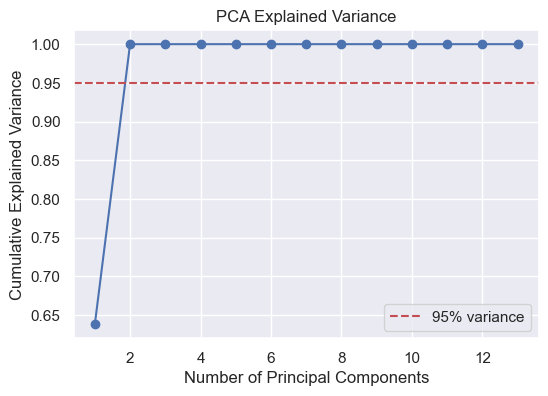

In [207]:
import matplotlib.pyplot as plt
import numpy as np

cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.95, color='r', linestyle='--', label='95% variance')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.legend()
plt.show()


In [208]:
n_components_95 = np.argmax(cum_var >= 0.95) + 1
print(f"Number of components to explain 95% variance: {n_components_95}")

Number of components to explain 95% variance: 2


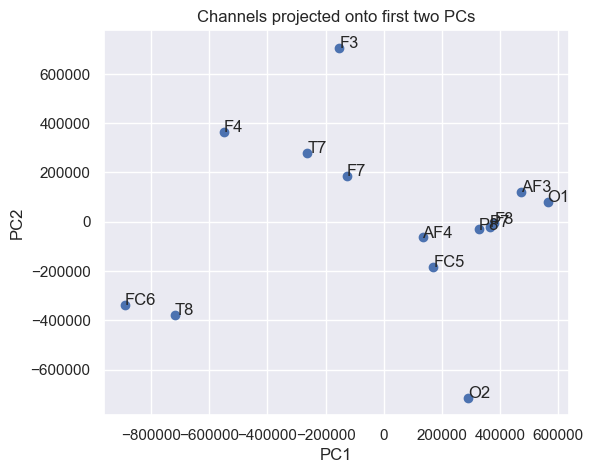

In [209]:
plt.figure(figsize=(6,5))
plt.scatter(features_pca[:,0], features_pca[:,1])

for i, ch in enumerate(features_df.index):
    plt.text(features_pca[i,0], features_pca[i,1], ch)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Channels projected onto first two PCs")
plt.grid(True)
plt.show()


In [210]:
print("Shape of PCA output:", features_pca.shape)

Shape of PCA output: (14, 13)


## eldonia f elsection elfat ma3koka🤩🤩🤩

## create widows

In [257]:
y=pd.DataFrame(y)

In [253]:
X_windows ,y_windows=helper_functions.create_windows(eeg_norm,y,3,0.5)

X_windows.shape
y_windows

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [239]:
y

,0
0,1
1,1
2,1
3,1
4,0
...,...
72,0
73,0
74,0
75,0


In [261]:
win_sizes=[1,2,3,4,5]
diffrent_windows={}

for i in win_sizes:
    X_windows ,y_windows=helper_functions.create_windows(eeg_norm,y,i,0.5)
    diffrent_windows[f"{i} sec windows"]=[X_windows,y_windows]
    print(f"created {X_windows.shape[0]} windows for {i} sec window size")
    print(y_windows)
    label_zero_count=len([i for i in y_windows if i==0])
    print(f"label distribution of {i} sec window is {label_zero_count} eye closed and {(len(y_windows)-label_zero_count)} eye open")

created 233 windows for 1 sec window size
[0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0]
label distribution of 1 sec window is 129 eye closed and 104 eye open
created 116 windows for 2 sec window size
[0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
label distribution of 2 sec window is 65 eye closed and 51 eye open
created 77 windows for 3 sec window size
[1 1 1 1 0 0 1 1 0 0 0 1 1

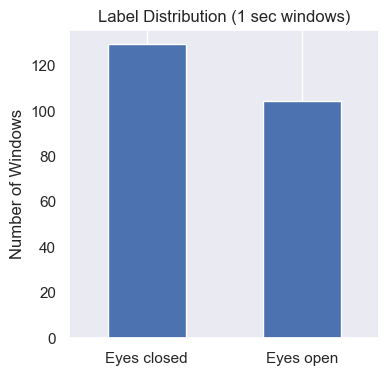

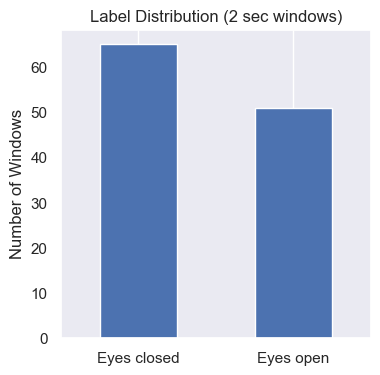

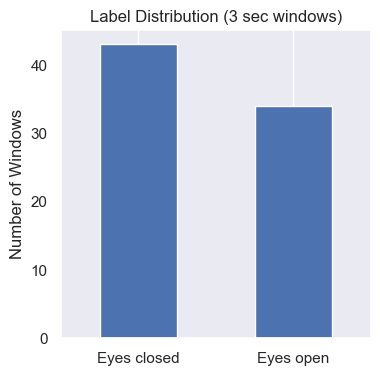

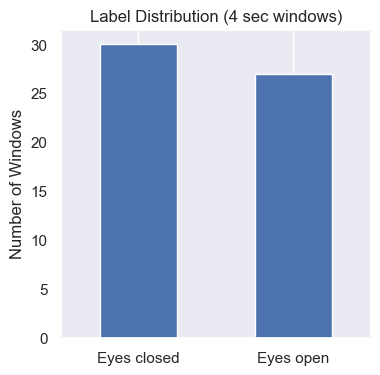

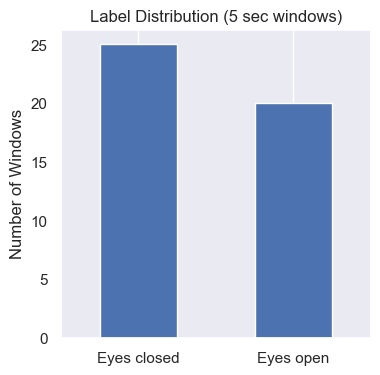

In [262]:
##label distribution
for i in win_sizes:
    
    y=diffrent_windows[f"{i} sec windows"][1]
    label_counts = pd.Series(y).value_counts().sort_index()

    plt.figure(figsize=(4,4))
    label_counts.plot(kind="bar")
    plt.xticks([0,1], ["Eyes closed", "Eyes open"], rotation=0)
    plt.ylabel("Number of Windows")
    plt.title(f"Label Distribution ({i} sec windows)")
    plt.grid(axis="y")
    plt.show()

## Extract features per window


<module 'helper_functions' from 'c:\\Users\\hana\\OneDrive\\Documents\\GitHub\\EEG-Eye-state-classifier\\helper_functions.py'>

In [216]:
X_1sec_window,y_1sec_window= diffrent_windows["1 sec windows"]

channel_names = eeg_df.columns.tolist()  

X_features = helper_functions.features_all_windows(
    X_1sec_window,
    channel_names,
    
)

print(X_features.shape)


(233, 182)


In [268]:
models = {
    "Logistic Regression": (
        LogisticRegression(max_iter=1000),
        {
            "clf__C": [0.01, 0.1, 1, 10]
        }
    ),

    "SVM (RBF)": (
        SVC(kernel="rbf"),
        {
            "clf__C": [0.1, 1, 10],
            "clf__gamma": ["scale", 0.01, 0.1]
        }
    ),

    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20]
        }
    ),

    "KNN": (
        KNeighborsClassifier(),
        {
            "clf__n_neighbors": [3, 5, 7, 9]
        }
    )
}


In [42]:
def evaluate_models(X, y, models):
    results = {}

    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    for name, (model, param_grid) in models.items():

        fold_accuracies = []
        best_params_per_fold = []

        for train_idx, test_idx in cv_outer.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            pipeline = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", model)
            ])

            grid = GridSearchCV(
                pipeline,
                param_grid,
                cv=3,
                scoring="accuracy",
                n_jobs=-1
            )

            grid.fit(X_train, y_train)

            y_pred = grid.predict(X_test)
            acc = accuracy_score(y_test, y_pred)

            fold_accuracies.append(acc)
            best_params_per_fold.append(grid.best_params_)

        results[name] = {
            "fold_accuracies": fold_accuracies,
            "mean_accuracy": np.mean(fold_accuracies),
            "std_accuracy": np.std(fold_accuracies),
            "best_params": best_params_per_fold
        }

        print(
            f"{name}: "
            f"{np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}"
        )

    return results


In [270]:
window_sizes = [1, 2, 3, 4, 5]
# sfreq = 128

all_results = {}

for win_sec in window_sizes:
    print(f"\n=== Window size: {win_sec} sec ===")

    X_windows, y_windows = diffrent_windows[f"{win_sec} sec windows"]

    X_features = helper_functions.features_all_windows(
        X_windows,
        channel_names,
        sfreq
    )

    # Convert to numpy for sklearn indexing
    X_features = X_features.values
    y_windows = np.array(y_windows)

    results = evaluate_models(X_features, y_windows, models)

    all_results[win_sec] = results



=== Window size: 1 sec ===
Logistic Regression: 0.6605 ± 0.0816
SVM (RBF): 0.5538 ± 0.0150
Random Forest: 0.5716 ± 0.0504
KNN: 0.6435 ± 0.0957

=== Window size: 2 sec ===
Logistic Regression: 0.6273 ± 0.1338
SVM (RBF): 0.5598 ± 0.0268
Random Forest: 0.5970 ± 0.0997
KNN: 0.5500 ± 0.1523

=== Window size: 3 sec ===
Logistic Regression: 0.6375 ± 0.1464
SVM (RBF): 0.6179 ± 0.2053
Random Forest: 0.6500 ± 0.1427
KNN: 0.6232 ± 0.1375

=== Window size: 4 sec ===
Logistic Regression: 0.7067 ± 0.1511
SVM (RBF): 0.6533 ± 0.1222
Random Forest: 0.6133 ± 0.0980
KNN: 0.6733 ± 0.2026

=== Window size: 5 sec ===
Logistic Regression: 0.6900 ± 0.1338
SVM (RBF): 0.5550 ± 0.0907
Random Forest: 0.6050 ± 0.1440
KNN: 0.5400 ± 0.2022


<module 'helper_functions' from 'c:\\Users\\hana\\OneDrive\\Documents\\GitHub\\EEG-Eye-state-classifier\\helper_functions.py'>

In [282]:
y

0        0
1        0
2        0
3        0
4        0
        ..
14975    1
14976    1
14977    1
14978    1
14979    1
Name: eyeDetection, Length: 14980, dtype: int64

In [67]:
seq_x,seq_y=helper_functions.create_sequences(eeg_norm,y,128)
print(seq_x.shape)
print(seq_y.shape)

torch.Size([117, 128, 14])
torch.Size([117, 128])


In [68]:

X_train, X_test, y_train, y_test = train_test_split(
    seq_x,
    seq_y,
    test_size=0.2,
    random_state=42,
    stratify=seq_y[:, 0]   
)

In [69]:

batch_size = 16

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size=batch_size,
    shuffle=False
)


In [70]:


class BiLSTM(nn.Module):
    def __init__(self, n_channels, hidden_size,dropout=0.3):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=n_channels,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        # x: (batch, seq_len, channels)
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out)  # (batch, seq_len, 1)
        return out


In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTM(n_channels=14, hidden_size=64).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


In [84]:
def train_model(model, train_loader, val_loader, epochs=70, patience=20):
    best_loss = np.inf
    patience_counter = 0

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)

            optimizer.zero_grad()
            outputs = model(Xb).squeeze(-1)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                outputs = model(Xb).squeeze(-1)
                loss = criterion(outputs, yb)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: train={train_loss:.4f}, val={val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_model=model
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    return best_model,train_losses, val_losses


In [85]:
best_model,train_losses, val_losses = train_model(
    model,
    train_loader,
    test_loader
)


Epoch 1: train=0.6904, val=0.6913
Epoch 2: train=0.6900, val=0.6913
Epoch 3: train=0.6902, val=0.6913
Epoch 4: train=0.6904, val=0.6913
Epoch 5: train=0.6902, val=0.6913
Epoch 6: train=0.6903, val=0.6913
Epoch 7: train=0.6897, val=0.6913
Epoch 8: train=0.6894, val=0.6913
Epoch 9: train=0.6903, val=0.6912
Epoch 10: train=0.6898, val=0.6912
Epoch 11: train=0.6898, val=0.6912
Epoch 12: train=0.6907, val=0.6912
Epoch 13: train=0.6900, val=0.6912
Epoch 14: train=0.6897, val=0.6912
Epoch 15: train=0.6898, val=0.6912
Epoch 16: train=0.6906, val=0.6912
Epoch 17: train=0.6895, val=0.6912
Epoch 18: train=0.6904, val=0.6912
Epoch 19: train=0.6900, val=0.6912
Epoch 20: train=0.6895, val=0.6912
Epoch 21: train=0.6897, val=0.6912
Epoch 22: train=0.6895, val=0.6912
Epoch 23: train=0.6897, val=0.6912
Epoch 24: train=0.6900, val=0.6911
Epoch 25: train=0.6898, val=0.6911
Epoch 26: train=0.6904, val=0.6911
Epoch 27: train=0.6903, val=0.6911
Epoch 28: train=0.6896, val=0.6911
Epoch 29: train=0.6893, val=0

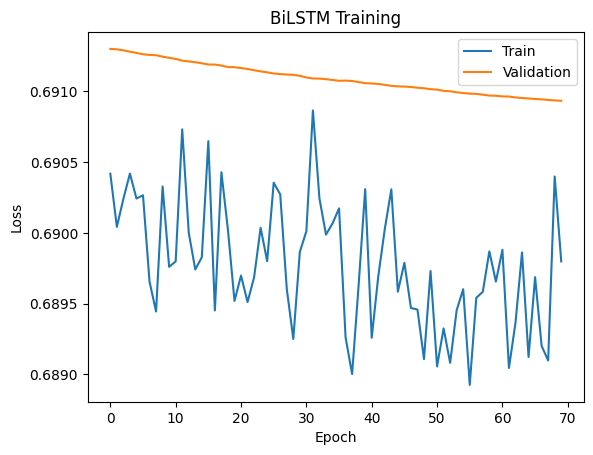

In [86]:


plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BiLSTM Training")
plt.show()


In [87]:
best_model,train_losses, val_losses = train_model(
    model,
    train_loader,
    test_loader,
    100
)

Epoch 1: train=0.6887, val=0.6909
Epoch 2: train=0.6887, val=0.6909
Epoch 3: train=0.6887, val=0.6909
Epoch 4: train=0.6889, val=0.6909
Epoch 5: train=0.6890, val=0.6909
Epoch 6: train=0.6889, val=0.6909
Epoch 7: train=0.6895, val=0.6909
Epoch 8: train=0.6883, val=0.6909
Epoch 9: train=0.6888, val=0.6909
Epoch 10: train=0.6885, val=0.6909
Epoch 11: train=0.6892, val=0.6909
Epoch 12: train=0.6892, val=0.6909
Epoch 13: train=0.6890, val=0.6909
Epoch 14: train=0.6893, val=0.6909
Epoch 15: train=0.6888, val=0.6909
Epoch 16: train=0.6882, val=0.6909
Epoch 17: train=0.6893, val=0.6909
Epoch 18: train=0.6887, val=0.6909
Epoch 19: train=0.6894, val=0.6909
Epoch 20: train=0.6891, val=0.6909
Epoch 21: train=0.6892, val=0.6909
Epoch 22: train=0.6888, val=0.6909
Epoch 23: train=0.6882, val=0.6909
Epoch 24: train=0.6881, val=0.6909
Epoch 25: train=0.6889, val=0.6908
Epoch 26: train=0.6899, val=0.6908
Epoch 27: train=0.6888, val=0.6908
Epoch 28: train=0.6886, val=0.6908
Epoch 29: train=0.6893, val=0

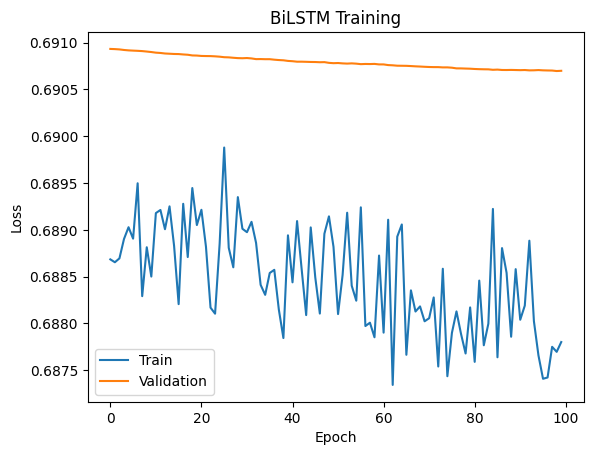

In [88]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BiLSTM Training")
plt.show()


In [133]:
def evaluate(model, test_loader):
    model.eval()

    all_preds = []
    all_true = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)          # (B, T, 1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.65).long()      # (B, T, 1)

            preds = preds.squeeze(-1)         # ✅ (B, T)
            y_batch = y_batch.long()          # ensure integer labels

            all_preds.append(preds.cpu())
            all_true.append(y_batch.cpu())

    y_pred_flat = torch.cat(all_preds).reshape(-1).numpy()
    y_true_flat = torch.cat(all_true).reshape(-1).numpy()

    return y_true_flat, y_pred_flat


In [90]:


y_true_flat,y_pred_flat=evaluate(best_model,test_loader)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.55      0.98      0.71      1716
   Eyes open       0.11      0.00      0.01      1356

    accuracy                           0.55      3072
   macro avg       0.33      0.49      0.36      3072
weighted avg       0.36      0.55      0.40      3072



In [91]:
best_model,train_losses, val_losses = train_model(
    model,
    train_loader,
    test_loader,
    1000
)

Epoch 1: train=0.6890, val=0.6907
Epoch 2: train=0.6879, val=0.6907
Epoch 3: train=0.6881, val=0.6907
Epoch 4: train=0.6880, val=0.6907
Epoch 5: train=0.6883, val=0.6907
Epoch 6: train=0.6878, val=0.6907
Epoch 7: train=0.6884, val=0.6907
Epoch 8: train=0.6884, val=0.6907
Epoch 9: train=0.6883, val=0.6907
Epoch 10: train=0.6874, val=0.6907
Epoch 11: train=0.6885, val=0.6907
Epoch 12: train=0.6879, val=0.6907
Epoch 13: train=0.6879, val=0.6907
Epoch 14: train=0.6879, val=0.6907
Epoch 15: train=0.6869, val=0.6907
Epoch 16: train=0.6880, val=0.6907
Epoch 17: train=0.6877, val=0.6907
Epoch 18: train=0.6876, val=0.6907
Epoch 19: train=0.6875, val=0.6907
Epoch 20: train=0.6883, val=0.6907
Epoch 21: train=0.6884, val=0.6907
Epoch 22: train=0.6874, val=0.6907
Epoch 23: train=0.6879, val=0.6907
Epoch 24: train=0.6864, val=0.6907
Epoch 25: train=0.6878, val=0.6907
Epoch 26: train=0.6873, val=0.6907
Epoch 27: train=0.6876, val=0.6907
Epoch 28: train=0.6880, val=0.6907
Epoch 29: train=0.6867, val=0

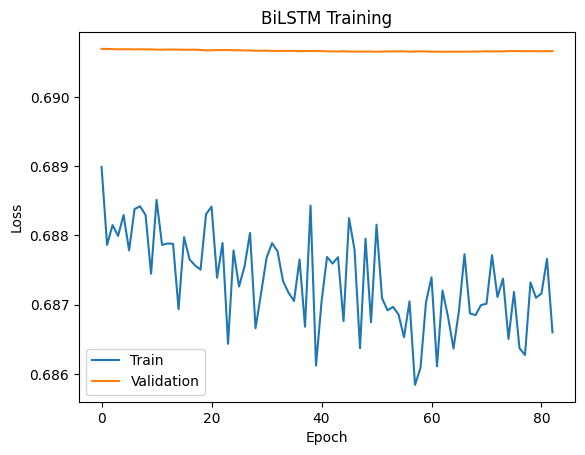

In [92]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BiLSTM Training")
plt.show()


In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTM(n_channels=14, hidden_size=64).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


In [94]:
best_model,train_losses, val_losses = train_model(
    model,
    train_loader,
    test_loader,
    1000,
    100
)

Epoch 1: train=0.6983, val=0.6966
Epoch 2: train=0.6983, val=0.6965
Epoch 3: train=0.6977, val=0.6965
Epoch 4: train=0.6977, val=0.6965
Epoch 5: train=0.6983, val=0.6964
Epoch 6: train=0.6979, val=0.6964
Epoch 7: train=0.6983, val=0.6963
Epoch 8: train=0.6980, val=0.6963
Epoch 9: train=0.6984, val=0.6962
Epoch 10: train=0.6975, val=0.6962
Epoch 11: train=0.6983, val=0.6962
Epoch 12: train=0.6978, val=0.6961
Epoch 13: train=0.6977, val=0.6961
Epoch 14: train=0.6978, val=0.6960
Epoch 15: train=0.6972, val=0.6960
Epoch 16: train=0.6971, val=0.6959
Epoch 17: train=0.6978, val=0.6959
Epoch 18: train=0.6969, val=0.6958
Epoch 19: train=0.6977, val=0.6958
Epoch 20: train=0.6974, val=0.6958
Epoch 21: train=0.6965, val=0.6957
Epoch 22: train=0.6975, val=0.6957
Epoch 23: train=0.6975, val=0.6956
Epoch 24: train=0.6967, val=0.6956
Epoch 25: train=0.6971, val=0.6955
Epoch 26: train=0.6970, val=0.6955
Epoch 27: train=0.6968, val=0.6955
Epoch 28: train=0.6970, val=0.6954
Epoch 29: train=0.6964, val=0

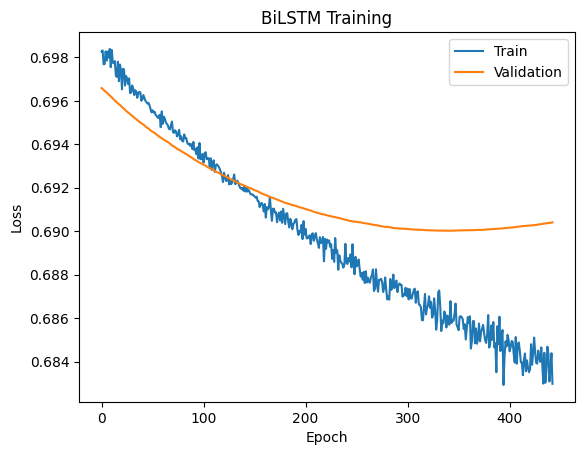

In [95]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BiLSTM Training")
plt.show()


In [96]:
class CNN_BiLSTM(nn.Module):
    def __init__(self, n_channels):
        super().__init__()

        self.conv1 = nn.Conv1d(n_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)

        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=64,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64 * 2, 1)

    def forward(self, x):
        # x: (batch, seq, channels)
        x = x.permute(0, 2, 1)        # (batch, channels, seq)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))

        x = x.permute(0, 2, 1)        # (batch, seq, features)

        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out)
        return out


In [97]:
cnn_lstm = CNN_BiLSTM(n_channels=14).to(device)

optimizer = torch.optim.Adam(cnn_lstm.parameters(), lr=1e-5)

best_model,train_losses, val_losses = train_model(
    cnn_lstm,
    train_loader,
    test_loader,
    1000,
    100
)


Epoch 1: train=0.6924, val=0.6917
Epoch 2: train=0.6925, val=0.6915
Epoch 3: train=0.6924, val=0.6914
Epoch 4: train=0.6919, val=0.6913
Epoch 5: train=0.6924, val=0.6912
Epoch 6: train=0.6921, val=0.6911
Epoch 7: train=0.6921, val=0.6910
Epoch 8: train=0.6921, val=0.6908
Epoch 9: train=0.6916, val=0.6908
Epoch 10: train=0.6917, val=0.6906
Epoch 11: train=0.6918, val=0.6905
Epoch 12: train=0.6921, val=0.6904
Epoch 13: train=0.6917, val=0.6903
Epoch 14: train=0.6919, val=0.6902
Epoch 15: train=0.6915, val=0.6902
Epoch 16: train=0.6917, val=0.6900
Epoch 17: train=0.6912, val=0.6900
Epoch 18: train=0.6916, val=0.6898
Epoch 19: train=0.6918, val=0.6898
Epoch 20: train=0.6913, val=0.6897
Epoch 21: train=0.6912, val=0.6897
Epoch 22: train=0.6915, val=0.6896
Epoch 23: train=0.6908, val=0.6896
Epoch 24: train=0.6911, val=0.6894
Epoch 25: train=0.6909, val=0.6894
Epoch 26: train=0.6910, val=0.6893
Epoch 27: train=0.6912, val=0.6892
Epoch 28: train=0.6912, val=0.6891
Epoch 29: train=0.6910, val=0

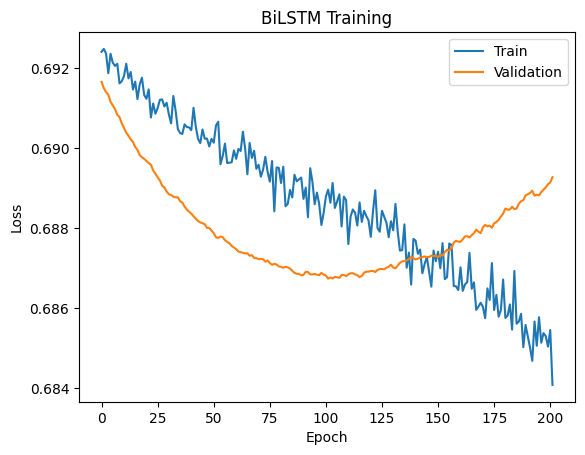

In [98]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BiLSTM Training")
plt.show()


In [99]:


y_true_flat,y_pred_flat=evaluate(best_model,test_loader)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.55      0.97      0.70      1716
   Eyes open       0.24      0.01      0.03      1356

    accuracy                           0.55      3072
   macro avg       0.40      0.49      0.37      3072
weighted avg       0.42      0.55      0.40      3072



In [100]:
x_seq_4sec,y_seq_4sec=helper_functions.create_sequences(eeg_norm,y,128*4)

X_train_4sec,X_test_4sec,y_train_4sec,y_test_4sec=train_test_split(x_seq_4sec,
                                                                   y_seq_4sec,
                                                                   test_size=0.2,
                                                                   random_state=42,
                                                                   stratify=y_seq_4sec[:, 0])

train_loader_4sec=DataLoader(
    TensorDataset(X_train_4sec, y_train_4sec),
    batch_size=batch_size,
    shuffle=True
)

test_loader_4sec=DataLoader(
    TensorDataset(X_test_4sec,y_test_4sec),
    batch_size=batch_size,
    shuffle=True
)

In [101]:
cnn_lstm = CNN_BiLSTM(n_channels=14).to(device)

optimizer = torch.optim.Adam(cnn_lstm.parameters(), lr=1e-5)

best_model,train_losses, val_losses = train_model(
    cnn_lstm,
    train_loader_4sec,
    test_loader_4sec,
    1000,
    100
)


Epoch 1: train=0.6885, val=0.6859
Epoch 2: train=0.6923, val=0.6858
Epoch 3: train=0.6903, val=0.6858
Epoch 4: train=0.6915, val=0.6857
Epoch 5: train=0.6894, val=0.6857
Epoch 6: train=0.6883, val=0.6856
Epoch 7: train=0.6963, val=0.6855
Epoch 8: train=0.6892, val=0.6855
Epoch 9: train=0.6889, val=0.6855
Epoch 10: train=0.6908, val=0.6854
Epoch 11: train=0.6893, val=0.6854
Epoch 12: train=0.6921, val=0.6853
Epoch 13: train=0.6913, val=0.6853
Epoch 14: train=0.6893, val=0.6852
Epoch 15: train=0.6894, val=0.6852
Epoch 16: train=0.6934, val=0.6851
Epoch 17: train=0.6956, val=0.6851
Epoch 18: train=0.6892, val=0.6851
Epoch 19: train=0.6923, val=0.6850
Epoch 20: train=0.6932, val=0.6850
Epoch 21: train=0.6918, val=0.6850
Epoch 22: train=0.6913, val=0.6850
Epoch 23: train=0.6876, val=0.6850
Epoch 24: train=0.6841, val=0.6849
Epoch 25: train=0.6920, val=0.6849
Epoch 26: train=0.6916, val=0.6848
Epoch 27: train=0.6951, val=0.6848
Epoch 28: train=0.6910, val=0.6848
Epoch 29: train=0.6899, val=0

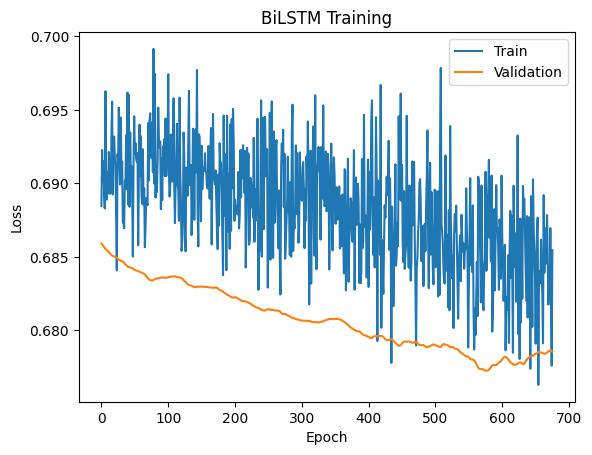

In [102]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BiLSTM Training")
plt.show()


In [103]:


y_true_flat,y_pred_flat=evaluate(model,test_loader_4sec)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.62      0.99      0.76      1905
   Eyes open       0.00      0.00      0.00      1167

    accuracy                           0.61      3072
   macro avg       0.31      0.49      0.38      3072
weighted avg       0.38      0.61      0.47      3072



In [104]:
cnn_lstm = CNN_BiLSTM(n_channels=14).to(device)

optimizer = torch.optim.Adam(cnn_lstm.parameters(), lr=5e-6)

best_model,train_losses, val_losses = train_model(
    cnn_lstm,
    train_loader_4sec,
    test_loader_4sec,
    5000,
    500
)


Epoch 1: train=0.6985, val=0.7124
Epoch 2: train=0.6988, val=0.7123
Epoch 3: train=0.7032, val=0.7122
Epoch 4: train=0.7072, val=0.7122
Epoch 5: train=0.6993, val=0.7120
Epoch 6: train=0.7015, val=0.7119
Epoch 7: train=0.6980, val=0.7118
Epoch 8: train=0.6970, val=0.7118
Epoch 9: train=0.7014, val=0.7117
Epoch 10: train=0.7024, val=0.7116
Epoch 11: train=0.7006, val=0.7115
Epoch 12: train=0.7040, val=0.7114
Epoch 13: train=0.6972, val=0.7113
Epoch 14: train=0.6944, val=0.7112
Epoch 15: train=0.7001, val=0.7111
Epoch 16: train=0.6950, val=0.7110
Epoch 17: train=0.7034, val=0.7109
Epoch 18: train=0.7010, val=0.7109
Epoch 19: train=0.7081, val=0.7108
Epoch 20: train=0.6960, val=0.7107
Epoch 21: train=0.6983, val=0.7106
Epoch 22: train=0.6970, val=0.7105
Epoch 23: train=0.6990, val=0.7104
Epoch 24: train=0.7037, val=0.7103
Epoch 25: train=0.7012, val=0.7103
Epoch 26: train=0.6949, val=0.7102
Epoch 27: train=0.6972, val=0.7101
Epoch 28: train=0.6980, val=0.7100
Epoch 29: train=0.7032, val=0

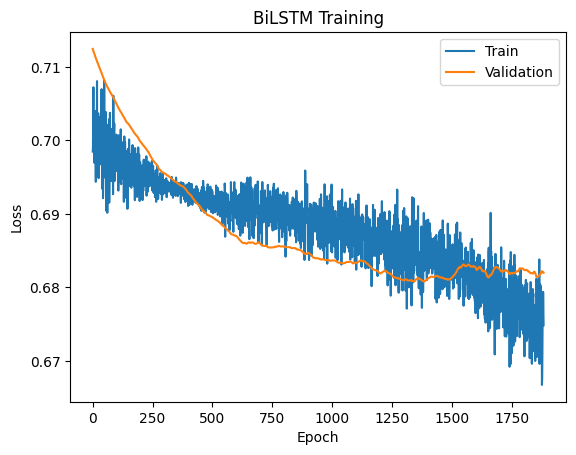

In [105]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BiLSTM Training")
plt.show()


In [106]:


y_true_flat,y_pred_flat=evaluate(best_model,test_loader_4sec)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.64      0.84      0.73      1905
   Eyes open       0.47      0.23      0.31      1167

    accuracy                           0.61      3072
   macro avg       0.56      0.54      0.52      3072
weighted avg       0.58      0.61      0.57      3072



In [118]:
cnn_lstm = CNN_BiLSTM(n_channels=14).to(device)

optimizer = torch.optim.Adam(cnn_lstm.parameters(), lr=5e-6)

best_model,train_losses, val_losses = train_model(
    cnn_lstm,
    train_loader_4sec,
    test_loader_4sec,
    5000,
    500
)


Epoch 1: train=0.6932, val=0.6961
Epoch 2: train=0.6938, val=0.6960
Epoch 3: train=0.6920, val=0.6960
Epoch 4: train=0.6925, val=0.6960
Epoch 5: train=0.6933, val=0.6960
Epoch 6: train=0.6939, val=0.6960
Epoch 7: train=0.6928, val=0.6960
Epoch 8: train=0.6945, val=0.6960
Epoch 9: train=0.6930, val=0.6960
Epoch 10: train=0.6939, val=0.6959
Epoch 11: train=0.6929, val=0.6959
Epoch 12: train=0.6927, val=0.6959
Epoch 13: train=0.6941, val=0.6959
Epoch 14: train=0.6943, val=0.6959
Epoch 15: train=0.6938, val=0.6958
Epoch 16: train=0.6944, val=0.6958
Epoch 17: train=0.6950, val=0.6957
Epoch 18: train=0.6937, val=0.6957
Epoch 19: train=0.6941, val=0.6956
Epoch 20: train=0.6934, val=0.6956
Epoch 21: train=0.6926, val=0.6955
Epoch 22: train=0.6934, val=0.6955
Epoch 23: train=0.6935, val=0.6955
Epoch 24: train=0.6933, val=0.6954
Epoch 25: train=0.6927, val=0.6954
Epoch 26: train=0.6937, val=0.6954
Epoch 27: train=0.6926, val=0.6953
Epoch 28: train=0.6926, val=0.6953
Epoch 29: train=0.6936, val=0

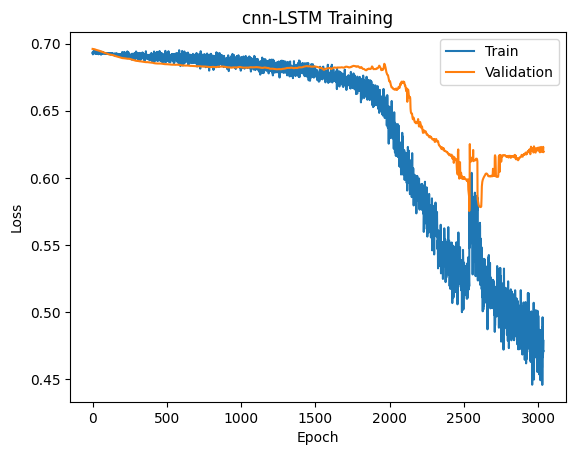

In [119]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("cnn-LSTM Training")
plt.show()


In [120]:

y_true_flat,y_pred_flat=evaluate(best_model,test_loader_4sec)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.65      0.90      0.75      1905
   Eyes open       0.55      0.19      0.28      1167

    accuracy                           0.63      3072
   macro avg       0.60      0.55      0.52      3072
weighted avg       0.61      0.63      0.57      3072



In [121]:

optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-6)

best_model,train_losses, val_losses = train_model(
    best_model,
    train_loader_4sec,
    test_loader_4sec,
    10000,
    1000
)


Epoch 1: train=0.5031, val=0.6193
Epoch 2: train=0.5014, val=0.6193
Epoch 3: train=0.4627, val=0.6192
Epoch 4: train=0.4606, val=0.6192
Epoch 5: train=0.4848, val=0.6192
Epoch 6: train=0.4660, val=0.6192
Epoch 7: train=0.4743, val=0.6193
Epoch 8: train=0.4790, val=0.6193
Epoch 9: train=0.4620, val=0.6194
Epoch 10: train=0.4482, val=0.6194
Epoch 11: train=0.4891, val=0.6194
Epoch 12: train=0.4800, val=0.6194
Epoch 13: train=0.4949, val=0.6194
Epoch 14: train=0.4726, val=0.6195
Epoch 15: train=0.5047, val=0.6195
Epoch 16: train=0.4674, val=0.6195
Epoch 17: train=0.4856, val=0.6196
Epoch 18: train=0.4558, val=0.6195
Epoch 19: train=0.4917, val=0.6194
Epoch 20: train=0.4481, val=0.6189
Epoch 21: train=0.4671, val=0.6183
Epoch 22: train=0.4810, val=0.6175
Epoch 23: train=0.4659, val=0.6166
Epoch 24: train=0.4709, val=0.6160
Epoch 25: train=0.4701, val=0.6156
Epoch 26: train=0.4727, val=0.6154
Epoch 27: train=0.4590, val=0.6153
Epoch 28: train=0.4730, val=0.6153
Epoch 29: train=0.4758, val=0

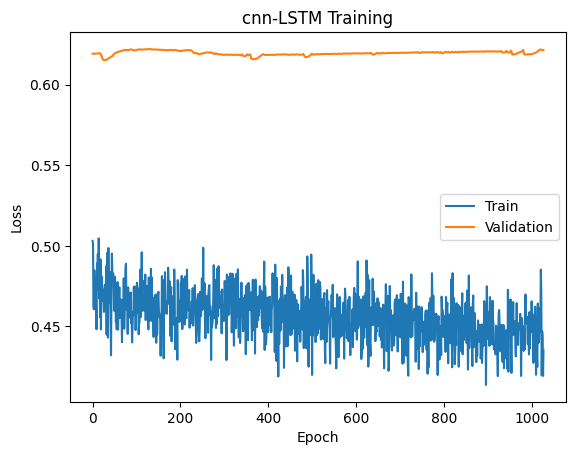

In [122]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("cnn-LSTM Training")
plt.show()


In [123]:

y_true_flat,y_pred_flat=evaluate(best_model,test_loader_4sec)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.65      0.87      0.75      1905
   Eyes open       0.54      0.25      0.34      1167

    accuracy                           0.64      3072
   macro avg       0.60      0.56      0.55      3072
weighted avg       0.61      0.64      0.59      3072



In [124]:

optimizer = torch.optim.Adam(best_model.parameters(), lr=3e-6)

best_model,train_losses, val_losses = train_model(
    best_model,
    train_loader_4sec,
    test_loader_4sec,
    10000,
    1000
)


Epoch 1: train=0.4636, val=0.6205
Epoch 2: train=0.4554, val=0.6229
Epoch 3: train=0.4639, val=0.6241
Epoch 4: train=0.4447, val=0.6246
Epoch 5: train=0.4440, val=0.6243
Epoch 6: train=0.4408, val=0.6235
Epoch 7: train=0.4335, val=0.6225
Epoch 8: train=0.4454, val=0.6213
Epoch 9: train=0.4422, val=0.6209
Epoch 10: train=0.4462, val=0.6210
Epoch 11: train=0.4660, val=0.6215
Epoch 12: train=0.4360, val=0.6228
Epoch 13: train=0.4557, val=0.6238
Epoch 14: train=0.4444, val=0.6244
Epoch 15: train=0.4829, val=0.6249
Epoch 16: train=0.4411, val=0.6252
Epoch 17: train=0.4457, val=0.6254
Epoch 18: train=0.4265, val=0.6255
Epoch 19: train=0.4474, val=0.6254
Epoch 20: train=0.4475, val=0.6251
Epoch 21: train=0.4414, val=0.6246
Epoch 22: train=0.4254, val=0.6239
Epoch 23: train=0.4370, val=0.6234
Epoch 24: train=0.4432, val=0.6217
Epoch 25: train=0.4606, val=0.6207
Epoch 26: train=0.4258, val=0.6203
Epoch 27: train=0.4535, val=0.6199
Epoch 28: train=0.4374, val=0.6196
Epoch 29: train=0.4379, val=0

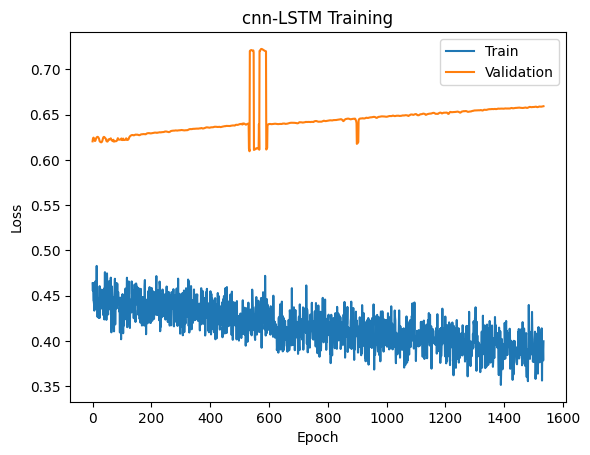

In [125]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("cnn-LSTM Training")
plt.show()


In [126]:

y_true_flat,y_pred_flat=evaluate(best_model,test_loader_4sec)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.64      0.81      0.72      1905
   Eyes open       0.47      0.26      0.34      1167

    accuracy                           0.61      3072
   macro avg       0.55      0.54      0.53      3072
weighted avg       0.58      0.61      0.57      3072



In [ ]:
#0.65 treshold
y_true_flat,y_pred_flat=evaluate(best_model,test_loader_4sec)

print(
    classification_report(
        y_true_flat,
        y_pred_flat,
        target_names=["Eyes closed", "Eyes open"]
    )
)


              precision    recall  f1-score   support

 Eyes closed       0.63      0.95      0.76      1905
   Eyes open       0.57      0.10      0.18      1167

    accuracy                           0.63      3072
   macro avg       0.60      0.53      0.47      3072
weighted avg       0.61      0.63      0.54      3072

